# バイアス・バリアンス
- バイアスの大きいモデルとバリアンスの大きいモデルの性質を確認しよう
- 参考：パターン認識と機械学習 上（C.M.ビショップ） 3.2節

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# L2正則化つき線形回帰モデル
from sklearn.linear_model import Ridge 
# 多項式特徴量を計算する前処理用の関数
from sklearn.preprocessing import PolynomialFeatures
# 機械学習パイプラインを作成するための関数
from sklearn.pipeline import make_pipeline

## 2. 真の関数（理想的なモデル）の作成
- 通常、これは観測できない

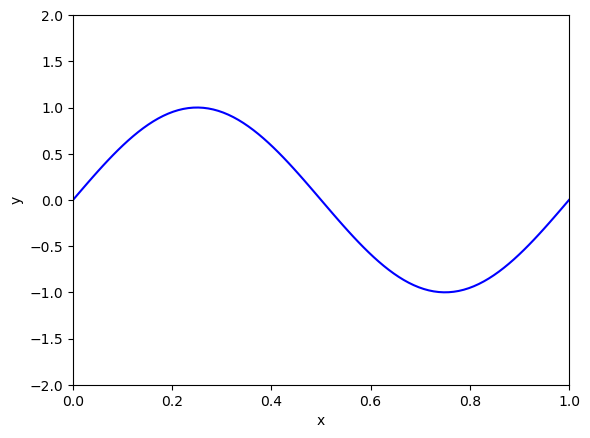

In [2]:
def f(x):
    return np.sin(2 * np.pi * x)

# x座標の値を計算
x_plot = np.linspace(0, 1, 100)
# y座標の値を計算
y = f(x_plot)
# 理想的なモデルの曲線を表示
plt.plot(x_plot, y, color='b')

plt.ylim((-2, 2))
plt.xlim((0, 1))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 3. ノイズを含むデータの生成
- 通常、観測されるデータはこのようなもの

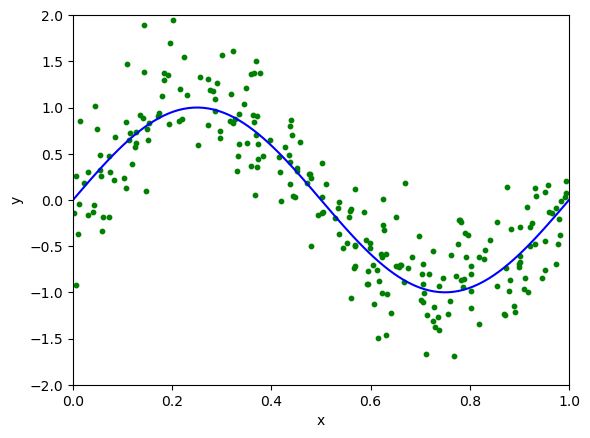

In [3]:
# sin(2πx)を関数として定義
def f(x):
    return np.sin(2 * np.pi * x)

# 乱数シードの固定
np.random.seed(1234)

L =10 # データを生成する回数
N = 25 # データ生成1回あたりのサイズ
n_total = N*L # データサイズの総計

# x座標をランダムに決める
x = np.random.uniform(0, 1, size=n_total).reshape(N ,L)
# ノイズ込みでデータを生成
y = f(x) + np.random.normal(scale=0.4, size=n_total).reshape(N, L)
# 理想的なモデル（青色の曲線）
plt.plot(x_plot, f(x_plot), color='b')
# ノイズを含むデータ（緑色の点）
plt.scatter(x, y, s=10, color="g")
# 表示範囲などの調整
plt.ylim((-2, 2))
plt.xlim((0, 1))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 4. モデルの構築・学習

#### [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- データから多項式特徴量を生成するメソッド
- 引数degreeで次数を設定
- 主に[pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)の中に組み込んで、モデルの入力として使用
#### degreeの値による特徴量の違い
- degree=0:$y=a_0$  
- degree=1:$y=a_0+a_1x$  
- degree=3:$y=a_0+a_1x+a_2x^2+a_3x^3$  
- degree=9:$y=a_0+\sum_{i=1}^9 {a_ix^i}$  

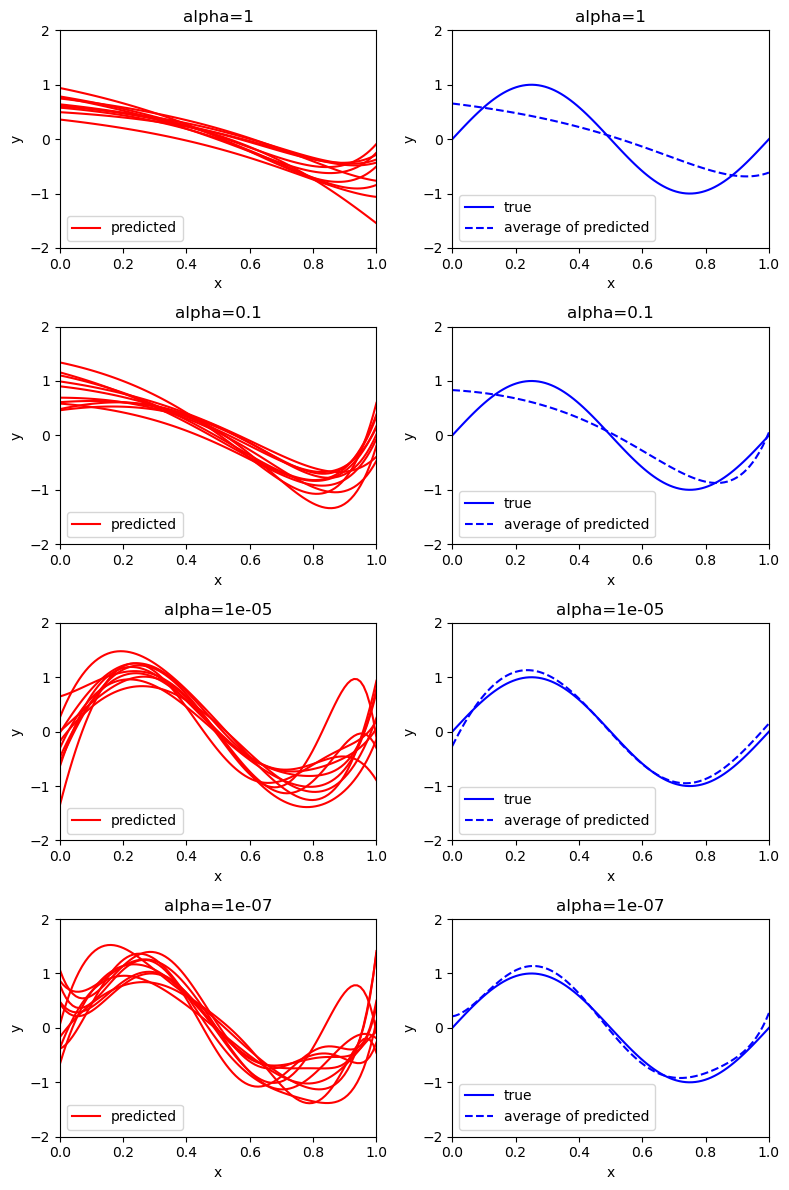

In [4]:
# 正則化係数を4つ指定
alphas = [1, 1e-1, 1e-5, 1e-7] 
# 多項式回帰の次数を設定（9に固定）
degree = 9
# 4x2の描画エリアを作成
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 12))

# グラフを表示する場所（ax）を指定
for alpha, ax_row in zip(alphas, ax_rows):
    # N行目のグラフ（N個目のalphaを適用）
    ax_left, ax_right = ax_row    
    # 左列のグラフ
    # 表示範囲などの設定
    ax_left.set_ylim((-2, 2))
    ax_left.set_xlim((0, 1))
    ax_left.set_ylabel('y')
    ax_left.set_xlabel('x')  
    ax_left.set_title("alpha=%s"%alpha)
    # 予測値を保存するための2次元配列
    # (データサイズ,データを生成する回数)
    y_pred = np.zeros((x_plot.shape[0], L))
    for i in range(L):  
        # データを1回分取り出す
        x_ = x[:, i].reshape(-1,1)
        y_ = y[:, i]    
        # パイプラインの構築
        model = make_pipeline(
            PolynomialFeatures(degree), 
            Ridge(alpha=alpha, random_state=1234)
        )
        # モデルの学習
        model.fit(x_, y_)     
        # 予測値を算出
        y_p = model.predict(x_plot.reshape(-1,1))
        # 予測値を配列に追加
        y_pred[:, i] = y_p
        # 予測値のグラフ（赤色の曲線）
        if i==0:
            ax_left.plot(x_plot, y_p, color='r', label="predicted")
            ax_left.legend(loc="lower left")
        else:
            # 同じalphaの場合は、同じaxに重ねて描画
            ax_left.plot(x_plot, y_p, color='r')
            
    # 右列のグラフ
    # 理想的なモデル（青色の曲線）
    ax_right.plot(x_plot, f(x_plot), color="b")
    # L個のモデルから得た予測値の平均（青色の点線）
    ax_right.plot(x_plot, y_pred.mean(axis=1), color="b", ls="--")
    # 表示範囲などの設定
    ax_right.set_ylim((-2, 2))
    ax_right.set_xlim((0, 1))
    ax_right.set_ylabel('y')
    ax_right.set_xlabel('x')
    ax_right.set_title("alpha=%s"%alpha)
    ax_right.legend(["true","average of predicted"], loc="lower left")

# 各グラフの表示位置を調整    
plt.tight_layout()
plt.show()

* 予測（グラフではpredicted）がばらついているほど、バリアンスが大きい
* 真の関数(グラフではtrue)と予測の平均値（グラフではaverage of predicted）が重なっているほど、バイアスが小さい
* バリアンスを小さくしようとすると、バイアスが大きくなる
    - これをバイアスとバリアンスのトレードオフという

### [問]
- degree=9の場合、一番良いalphaはどれくらいだろうか？
  
### [演習]
- degreeやalphaの値をいろいろ変えて、結果がどう変わるか確認してみよう

### [参考]
- ランダムフォレストは、弱学習器（1つ1つは精度が低く、バリアンスが大きくなる）の平均をとることで、バイアスが小さい結果を得る方法と言える